In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

## 1. Q-learning in the wild (3 pts)

Here we use the qlearning agent on taxi env from openai gym.
You will need to insert a few agent functions here.

In [51]:
import random,math
import numpy as np
from collections import defaultdict

class QLearningAgent():
    """
    Q-Learning Agent

    Instance variables you have access to
      - self.epsilon (exploration prob)
      - self.alpha (learning rate)
      - self.discount (discount rate aka gamma)

    Functions you should use
      - self.getLegalActions(state)
        which returns legal actions for a state
      - self.getQValue(state,action)
        which returns Q(state,action)
      - self.setQValue(state,action,value)
        which sets Q(state,action) := value

    !!!Important!!!
    NOTE: please avoid using self._qValues directly to make code cleaner
    """
    def __init__(self,alpha,epsilon,discount,getLegalActions):

        self.getLegalActions = getLegalActions
        self._qValues = defaultdict(lambda:defaultdict(lambda:0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def getQValue(self, state, action):
        if not (state in self._qValues) or not (action in self._qValues[state]):
            return 0.0
        return self._qValues[state][action]

    def setQValue(self,state,action,value):

        self._qValues[state][action] = value

#---------------------#start of your code#---------------------#

    def getValue(self, state):
        
        possibleActions = self.getLegalActions(state)
        
        if len(possibleActions) == 0:
            return 0.0
        
        q_values = [self.getQValue(state, action) for action in possibleActions]
        return max(q_values)

    def getPolicy(self, state):
        
        possibleActions = self.getLegalActions(state)
        
        if len(possibleActions) == 0:
            return None
        
        best_action = None
        best_value = float('-inf')
        
        for action in possibleActions:
            q_value = self.getQValue(state, action)
            if q_value > best_value:
                best_value = q_value
                best_action = action
        
        best_actions = [action for action in possibleActions 
                       if self.getQValue(state, action) == best_value]
        
        return random.choice(best_actions) if best_actions else None

    def getAction(self, state):
       
        possibleActions = self.getLegalActions(state)
        
        if len(possibleActions) == 0:
            return None
        
        if random.random() < self.epsilon:
            action = random.choice(possibleActions)
        else:
            action = self.getPolicy(state)
            if action is None:
                action = random.choice(possibleActions)
        
        return action

    def update(self, state, action, nextState, reward):
        
        current_q = self.getQValue(state, action)
        next_value = self.getValue(nextState)
        new_q = current_q + self.alpha * (reward + self.discount * next_value - current_q)
        self.setQValue(state, action, new_q)

In [46]:
import gymnasium as gym
env = gym.make("Taxi-v3")
n_actions = env.action_space.n

In [47]:
def play_and_train(env, agent, t_max=10**4):
    """This function should
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total reward"""
    total_reward = 0.0
    
    s, info = env.reset()
    
    for t in range(t_max):
        a = agent.getAction(s)
        
        next_s, r, terminated, truncated, info = env.step(a)
        done = terminated or truncated
        agent.update(s, a, next_s, r)
        
        s = next_s
        total_reward += r
        
        if done:
            break
    
    return total_reward

In [48]:
agent = QLearningAgent(alpha=0.1, epsilon=0.1, discount=0.99,
                       getLegalActions = lambda s: range(n_actions))

Достигните положительной награды, постройте график

In [49]:
from IPython.display import clear_output


Final epsilon: 0.01
Average reward: -99.65
Max reward: 15.0


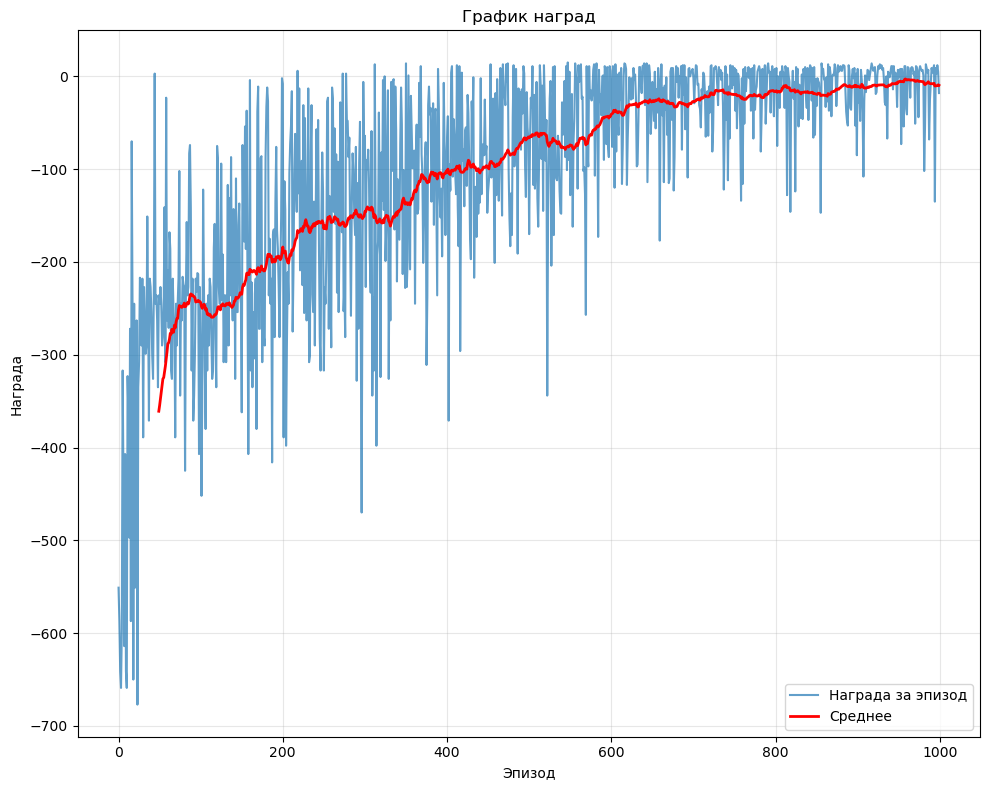

In [50]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

rewards = []
epsilon_values = []

for i in range(1000):
    reward = play_and_train(env, agent)
    rewards.append(reward)
    agent.epsilon = max(0.01, agent.epsilon * 0.995)
    epsilon_values.append(agent.epsilon)
    
    if i % 100 == 0:
        clear_output(wait=True)
        fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
        ax1.plot(rewards, label='Награда за эпизод', alpha=0.7)
        
        if len(rewards) >= 10:
            window_size = min(50, len(rewards))
            moving_avg = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
            ax1.plot(range(window_size-1, len(rewards)), moving_avg, 
                    'r-', linewidth=2, label='Среднее')
        
        ax1.set_xlabel('Эпизод')
        ax1.set_ylabel('Награда')
        ax1.set_title('График наград')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

clear_output(wait=True)
print('Final epsilon:', round(agent.epsilon, 3))
print('Average reward:', round(np.mean(rewards), 2))
print('Max reward:', round(np.max(rewards), 2))
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))

ax1.plot(rewards, label='Награда за эпизод', alpha=0.7)
if len(rewards) >= 10:
    window_size = min(50, len(rewards))
    moving_avg = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
    ax1.plot(range(window_size-1, len(rewards)), moving_avg, 
            'r-', linewidth=2, label='Среднее')
ax1.set_xlabel('Эпизод')
ax1.set_ylabel('Награда')
ax1.set_title('График наград')
ax1.legend()
ax1.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

## 3. Continuous state space (2 pt)

Чтобы использовать табличный q-learning на continuous состояниях, надо как-то их обрабатывать и бинаризовать. Придумайте способ разбивки на дискретные состояния.

In [38]:
import gymnasium as gym
import numpy as np
from collections import defaultdict

def create_bins(num_bins=10):
 
    bounds = [
        (-2.4, 2.4),
        (-4.0, 4.0),  
        (-0.2095, 0.2095),
        (-4.0, 4.0)   
    ]
    
    bins = []
    for lower, upper in bounds:
        bins.append(np.linspace(lower, upper, num_bins + 1)[1:-1]) 
    
    return bins

def discretize_state(state, bins):
    discretized = []
    for i, value in enumerate(state):
        discretized.append(np.digitize(value, bins[i]))
    return tuple(discretized)

env = gym.make("CartPole-v0")
state = env.reset()

state = state[0]

print(state)
bins = create_bins(num_bins=10)
discrete_state = discretize_state(state, bins)
print(discrete_state)

[ 0.00755151  0.0478964   0.02958386 -0.03838613]
(np.int64(5), np.int64(5), np.int64(5), np.int64(4))


### Play a few games

Постройте распределения различных частей состояния игры. Сыграйте несколько игр и запишите все состояния.

Позиция тележки
Min: -0.7143 Max: 1.0752
Mean: 0.0157 Std: 0.116

Скорость тележки
Min: -2.1383 Max: 1.8348
Mean: 0.0511 Std: 0.5382

Угол шеста
Min: -0.2094 Max: 0.2092
Mean: -0.0121 Std: 0.0914

Угловая скорость шеста
Min: -2.6201 Max: 2.6814
Mean: -0.0806 Std: 0.7901



/var/folders/2c/hhz7h1g50nl8vnl6_6zcldjw0000gn/T/ipykernel_52132/4193605207.py:85: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


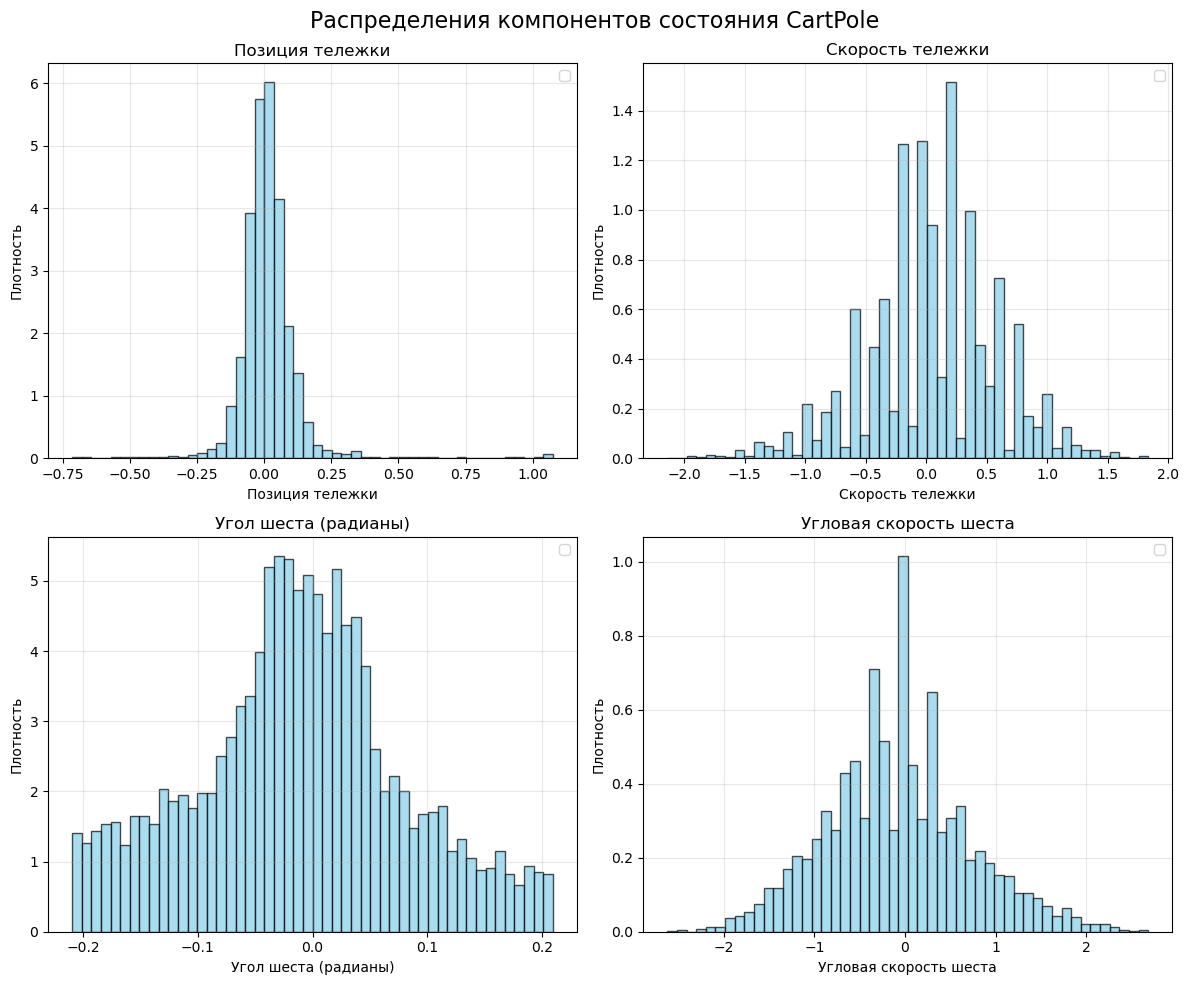

In [42]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

env = gym.make("CartPole-v0")


all_states = []
state_components = {
    'cart_position': [],
    'cart_velocity': [],
    'pole_angle': [],
    'pole_angular_velocity': []
}

def collect_states(num_episodes=100, max_steps_per_episode=200):
    for episode in range(num_episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]
        
        done = False
        steps = 0
        
        while not done and steps < max_steps_per_episode:
            all_states.append(state)
            state_components['cart_position'].append(state[0])
            state_components['cart_velocity'].append(state[1])
            state_components['pole_angle'].append(state[2])
            state_components['pole_angular_velocity'].append(state[3])
            
            action = env.action_space.sample()
            
            step_result = env.step(action)
            if len(step_result) == 4:
                next_state, reward, done, _ = step_result
            else:
                next_state, reward, terminated, truncated, _ = step_result
                done = terminated or truncated
            
            state = next_state
            steps += 1



collect_states(num_episodes=200, max_steps_per_episode=500)
all_states = np.array(all_states)
for key in state_components:
    state_components[key] = np.array(state_components[key])

component_names = [
    'Позиция тележки',
    'Скорость тележки',
    'Угол шеста',
    'Угловая скорость шеста'
]

for i, name in enumerate(component_names):
    data = all_states[:, i]
    print(name)
    print('Min:', round(data.min(),4), 'Max:', round(data.max(), 4))
    print('Mean:', round(data.mean(),4), 'Std:', round(data.std(), 4))
    print()

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Распределения компонентов состояния CartPole', fontsize=16)

components = [
    ('cart_position', 'Позиция тележки'),
    ('cart_velocity', 'Скорость тележки'),
    ('pole_angle', 'Угол шеста (радианы)'),
    ('pole_angular_velocity', 'Угловая скорость шеста')
]

for idx, (key, title) in enumerate(components):
    ax = axes[idx // 2, idx % 2]
    data = state_components[key]
    
    ax.hist(data, bins=50, alpha=0.7, density=True, color='skyblue', edgecolor='black')
    ax.set_xlabel(title)
    ax.set_ylabel('Плотность')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

env.close()



## Binarize environment

In [71]:
env = Binarizer(gym.make("CartPole-v0"))

## Learn

In [72]:
agent = QLearningAgent(alpha=0.1, epsilon=0.1, discount=0.99,
                       getLegalActions = lambda s: range(n_actions))

## 4. Experience replay (5 pts)

In [ ]:
import random
class ReplayBuffer(object):
    def __init__(self, size):
        """Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._storage = []
        self._maxsize = size
        self._replaceId = 0


    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        '''
        Make sure, _storage will not exceed _maxsize.
        '''
        data = (obs_t, action, reward, obs_tp1, done)
        if len(self._storage) == self._maxsize:
            #
        else:
            #

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """

        #

        return states, actions, rewards, next_states, is_done


Some tests to make sure your buffer works right

In [ ]:
import numpy as np
replay = ReplayBuffer(2)
obj1 = tuple(range(5))
obj2 = tuple(range(5, 10))
replay.add(*obj1)
assert replay.sample(1)==obj1, "If there's just one object in buffer, it must be retrieved by buf.sample(1)"
replay.add(*obj2)
assert len(replay._storage)==2, "Please make sure __len__ methods works as intended."
replay.add(*obj2)
assert len(replay._storage)==2, "When buffer is at max capacity, replace objects instead of adding new ones."
assert tuple(np.unique(a) for a in replay.sample(100))==obj2
replay.add(*obj1)
assert max(len(np.unique(a)) for a in replay.sample(100))==2
replay.add(*obj1)
assert tuple(np.unique(a) for a in replay.sample(100))==obj1
print ("Success!")

Now let's use this buffer to improve training:

In [ ]:
import gym
env = Binarizer(gym.make('CartPole-v0'))
n_actions = env.action_space.n

In [ ]:
agent = QLearningAgent(alpha=,epsilon=,discount=,
                       getLegalActions = lambda s: range(n_actions))
replay = ReplayBuffer(10000)

In [ ]:
def play_and_train(env, agent, t_max=10**4, batch_size=10):
    """This function should
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total reward"""
    total_reward = 0.0
    s = env.reset()

    for t in range(t_max):
        aсtion = agent.getAction(s)
        next_s, r, done,_ = env.step(aсtion)

        #заполните реплей
        #опционально - моежте также как в варианте без реплея обучаться по состояниям которые

        s = next_s
        total_reward +=r
        if done:break

    #learn from replay

    return total_reward




Train with experience replay

In [ ]:
rewards = []
rewBuf = []
ma = -1000000000000
for i in range(10000):
    for i in range(100):
        rewards.append(play_and_train(env,agent, batch_size=1000))
    agent.epsilon *= #
    rewBuf.append(np.mean(rewards[-100:]))
    clear_output(True)
    print(agent.epsilon)
    print(rewBuf[-1])
    plt.plot(rewBuf)
    if(rewBuf[-1] > 195):
        print("Win!")
        break
    plt.show()
